# Transfer learning with a pretrained MobileNetV2

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import PIL

import scipy

import pickle

import pandas as pd

from skimage import transform

from PIL import Image

import matplotlib.pyplot as plt

import time

In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, LSTM
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

keras = tf.keras

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [5]:
# If you need to abort this session run the command
# session.close()

Configure directories paths:

In [6]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

### Helper-function for printing confusion matrix


In [7]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix


def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")

    # Print the confusion matrix as text.
    print(cm)

    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

### Helper-function for plotting example errors

Function for plotting examples of images from the test-set that have been mis-classified.


In [8]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])

    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function for generating and plotting example errors

Function for calculating the predicted classes of the entire test-set and calling the above function to plot a few examples of mis-classified images.

In [9]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()

    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred, axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)

    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

### Helper-function for loading images

The data-set is not loaded into memory, instead it has a list of the files for the images in the training-set and another list of the files for the images in the test-set. This helper-function loads some image-files.

In [10]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

### Helper-function for plotting training history

This plots the classification accuracy and loss-values recorded during training with the Keras API.


In [11]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')

    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Dataset: Collision Avoidance

The Collision-avoidance dataset was introduced in Tutorial #09. It was generated from video-files by taking individual frames and converting them to images.

In [12]:
import dataset_ca

"""This dataset has another directory structure than the Keras API requires, so copy the files into separate directories for the training- and test-sets."""

# uncomment this linda is needed
# dataset_ca.copy_files()

Creating dataset from the files in: data/images/
- Data loaded from cache-file: data/images/collisions.pkl
/home/griffin/PycharmProjects/collision-avoidance/collision_avoidance/data/images/train/collision
/home/griffin/PycharmProjects/collision-avoidance/collision_avoidance/data/images/train/no_collision
/home/griffin/PycharmProjects/collision-avoidance/collision_avoidance/data/images/collision/colision32.mp4574.png
/home/griffin/PycharmProjects/collision-avoidance/collision_avoidance/data/images/collision/colision26.mp4297.png
/home/griffin/PycharmProjects/collision-avoidance/collision_avoidance/data/images/collision/colision32.mp4501.png
[1 1 2 2 2]
[[0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]]
[]
[]


'This dataset has another directory structure than the Keras API requires, so copy the files into separate directories for the training- and test-sets.'

The directories where the images are now stored.

In [13]:
train_dir = 'data/images/train/' # dataset_ca.train_dir
print(train_dir)
test_dir = 'data/images/train/' # dataset_ca.test_dir
print(test_dir)

data/images/train/
data/images/train/


## Load MobileNetV2 Model

In [14]:
IMG_SIZE = 224 # All images will be resized to 160x160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


### Input Pipeline

The Keras API has its own way of creating the input pipeline for training a model using files.

First we need to know the shape of the tensors expected as input by the pre-trained VGG16 model. In this case it is images of shape 224 x 224 x 3.

In [15]:
input_shape = base_model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

Keras uses a so-called data-generator for inputting data into the neural network, which will loop over the data for eternity.

We have a small training-set so it helps to artificially inflate its size by making various transformations to the images. We use a built-in data-generator that can make these random transformations. This is also called an augmented dataset.


In [16]:
datagen_train = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode='nearest')

We also need a data-generator for the test-set, but this should not do any transformations to the images because we want to know the exact classification accuracy on those specific images. So we just rescale the pixel-values so they are between 0.0 and 1.0 because this is expected by the model.

In [17]:
datagen_test = ImageDataGenerator(rescale=1. / 255)

The data-generators will return batches of images. Because the model is so large, the batch-size cannot be too large, otherwise you will run out of RAM on the GPU.

In [18]:
batch_size = 64

We can save the randomly transformed images during training, so as to inspect whether they have been overly distorted, so we have to adjust the parameters for the data-generator above.

In [19]:
if True:
    save_to_dir = None
else:
    save_to_dir = 'augmented_images/'

Now we create the actual data-generator that will read files from disk, resize the images and return a random batch.

It is somewhat awkward that the construction of the data-generator is split into these two steps, but it is probably because there are different kinds of data-generators available for different data-types (images, text, etc.) and sources (memory or disk).

In [20]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 6008 images belonging to 2 classes.


The data-generator for the test-set should not transform and not shuffle the images.

In [21]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=True)

Found 6008 images belonging to 2 classes.


Because the data-generators will loop for eternity, we need to specify the number of steps to perform during evaluation and prediction on the test-set. Because our test-set contains 530 images and the batch-size is set to 20, the number of steps is 26.5 for one full processing of the test-set. This is why we need to reset the data-generator's counter in the `example_errors()` function above, so it always starts processing from the beginning of the test-set.

This is another slightly awkward aspect of the Keras API which could perhaps be improved.


In [22]:
steps_test = generator_test.n / batch_size

Get the file-paths for all the images in the training- and test-sets.

In [23]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

Get the class-numbers for all the images in the training- and test-sets.

In [24]:
cls_train = generator_train.classes
cls_test = generator_test.classes

Get the class-names for the dataset.

In [25]:
class_names = list(generator_train.class_indices.keys())
class_names

['collision', 'no_collision']

Get the number of classes for the dataset.

In [26]:
num_classes = generator_train.num_classes
num_classes

2

### Class Weights

The Collision Avoidance dataset is quite imbalanced because it has few images of collisions, more images of free flight. This can cause a problem during training because the neural network will be shown many more examples of free flight.

Here we use scikit-learn to calculate weights that will properly balance the dataset. These weights are applied to the gradient for each image in the batch during training, so as to scale their influence on the overall gradient for the batch.

In [27]:
from sklearn.utils.class_weight import compute_class_weight

class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

Note how the weight is about 1.98 for the collision-class and only 0.66 for the nocollision-class. This is because there are fewer images for the collision-class so the gradient should be amplified for those images, while the gradient should be lowered for nocollision-images.

In [28]:
print(class_weight)

print(class_names)

[1. 1.]
['collision', 'no_collision']


In [29]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # the classes of the ImageNet-dataset.
    pred = base_model.predict(img_array)

Weird results before training

## Data preprocessing

### Data preparing

## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. ImageNet has a fairly arbitrary research training dataset with categories like `jackfruit` and `syringe`, but this base of knowledge will help us tell apart cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. Obviously, the very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful.  Instead, you will follow the common practice to instead depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck features retain much generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

This feature extractor converts each `240x240x3` image to a `5x5x1280` block of features. See what it does to the example batch of images:

## Feature extraction
You will freeze the convolutional base created from the previous step and use that as a feature extractor, add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base
It's important to freeze the convolutional based before you compile and train the model. By freezing (or setting `layer.trainable = False`), you prevent the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to `False` will freeze all the layers.

In [30]:
base_model.trainable = False

In [31]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(2, activation='softmax')

In [33]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value.  Positive numbers predict class 1, negative numbers predict class 0.

Now stack the feature extractor, and these two layers using a `tf.keras.Sequential` model:

### Compile the model

You must compile the model before training it.  Since there are two classes, use a binary cross-entropy loss.

In [34]:
base_learning_rate = 0.00001
#model.compile(loss='categorical_crossentropy',
#              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
#              metrics=['categorical_accuracy'])
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [36]:
# import pydot
# import graphviz
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png')

The 2.5M parameters in MobileNet are frozen, but there are 1.2K _trainable_ parameters in the Dense layer.  These are divided between two `tf.Variable` objects, the weights and biases.

### Train the model

After training for 10 epochs, you should see ~60% accuracy.

<!-- TODO(markdaoust): delete steps_per_epoch in TensorFlow r1.14/r2.0 -->

In [37]:
epochs = 20
steps_per_epoch = 100
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

print(class_weight)

history = model.fit_generator(generator=generator_train,
                                  epochs=epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  #class_weight={0:class_weight[0], 1:class_weight[1],},
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

[1. 1.]
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
100/100 [==============================] - 37s 369ms/step - loss: 0.8106 - accuracy: 0.5081 - val_loss: 0.9890 - val_accuracy: 0.5050
Epoch 2/20
100/100 [==============================] - 35s 354ms/step - loss: 0.7884 - accuracy: 0.5150 - val_loss: 0.9484 - val_accuracy: 0.5100
Epoch 3/20
100/100 [==============================] - 35s 354ms/step - loss: 0.7705 - accuracy: 0.5383 - val_loss: 0.9166 - val_accuracy: 0.5193
Epoch 4/20
100/100 [==============================] - 35s 354ms/step - loss: 0.7468 - accuracy: 0.5580 - val_loss: 0.8907 - val_accuracy: 0.5195
Epoch 5/20
100/100 [==============================] - 35s 354ms/step - loss: 0.7361 - accuracy: 0.5588 - val_loss: 0.8680 - val_accuracy: 0.5323
Epoch 6/20
100/100 [==============================] - 35s 354ms/step - loss: 0.7200 - accuracy: 0.5745 - val_loss: 0.8530 - val_accuracy: 0.5373
Epoch 7/20
100/100 [==========================

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

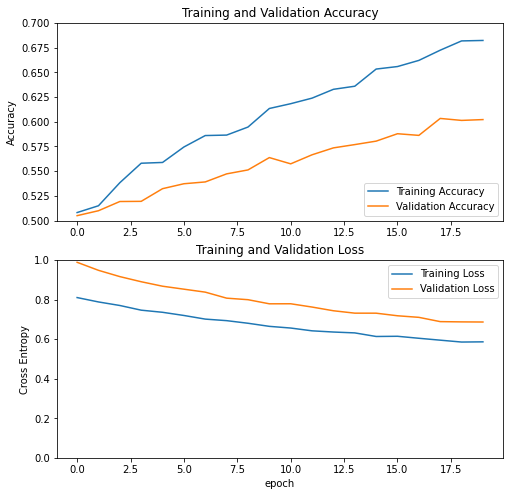

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5,0.7])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss.

To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

## Fine tuning
In our feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic features maps to features associated specifically to our dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features which generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

### Un-freeze the top layers of the model


All you need to do is unfreeze the `base_model` and set the bottom layers be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [39]:
model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


### Compile the model

Compile the model using a much lower training rate.

In [41]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 1,865,154
Non-trainable params: 395,392
_________________________________________________________________


In [43]:
len(model.trainable_variables)

58

### Continue Train the model

If you trained to convergence earlier, this will get you a few percent more accuracy.

In [44]:
fine_tune_epochs = 10
initial_epochs = epochs
total_epochs =  initial_epochs + epochs

history_fine = model.fit_generator(generator=generator_train,
                                  initial_epoch =  history.epoch[-1],
                                  epochs=total_epochs,
                                  steps_per_epoch=steps_per_epoch,
                                  #class_weight=class_weight,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)


Epoch 20/40
100/100 [==============================] - 36s 358ms/step - loss: 0.5573 - accuracy: 0.7076 - val_loss: 0.6653 - val_accuracy: 0.6127
Epoch 21/40
100/100 [==============================] - 35s 354ms/step - loss: 0.5234 - accuracy: 0.7367 - val_loss: 0.6537 - val_accuracy: 0.6223
Epoch 22/40
100/100 [==============================] - 35s 354ms/step - loss: 0.4848 - accuracy: 0.7722 - val_loss: 0.6311 - val_accuracy: 0.6353
Epoch 23/40
100/100 [==============================] - 36s 355ms/step - loss: 0.4591 - accuracy: 0.7843 - val_loss: 0.6189 - val_accuracy: 0.6500
Epoch 24/40
100/100 [==============================] - 35s 355ms/step - loss: 0.4370 - accuracy: 0.8044 - val_loss: 0.6149 - val_accuracy: 0.6585
Epoch 25/40
100/100 [==============================] - 36s 355ms/step - loss: 0.4123 - accuracy: 0.8295 - val_loss: 0.5844 - val_accuracy: 0.6751
Epoch 26/40
100/100 [==============================] - 36s 356ms/step - loss: 0.3889 - accuracy: 0.8392 - val_loss: 0.5929 -

Let's take a look at the learning curves of the training and validation accuracy/loss, when fine tuning the last few layers of the MobileNet V2 base model and training the classifier on top of it. The validation loss is much higher than the training loss, so you may get some overfitting.

You may also get some overfitting as the new training set is relatively small and similar to the original MobileNet V2 datasets.


After fine tuning the model nearly reaches 98% accuracy.

In [45]:
acc_f =  acc + history_fine.history['accuracy']
val_acc_f = val_acc + history_fine.history['val_accuracy']

loss_f = loss + history_fine.history['loss']
val_loss_f = val_loss + history_fine.history['val_loss']

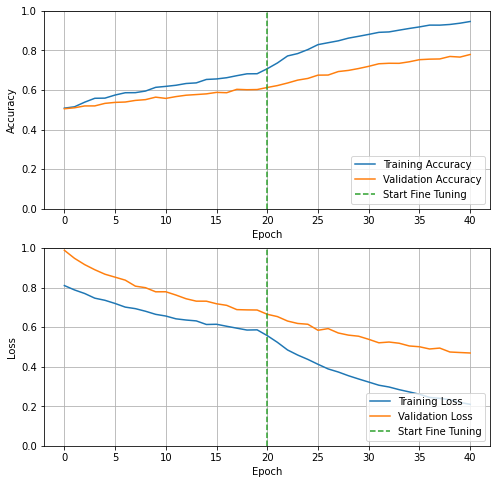

In [46]:
fig= plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1).grid()
plt.plot(acc_f, label='Training Accuracy')
plt.plot(val_acc_f, label='Validation Accuracy')

plt.ylim([0, 1])
plt.plot([initial_epochs,initial_epochs],
          plt.ylim(), '--', label='Start Fine Tuning')
plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_f, label='Training Loss')
plt.plot(val_loss_f, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs,initial_epochs],
         plt.ylim(), '--', label='Start Fine Tuning')
plt.legend(loc='lower right')
#plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()


In [47]:
NAME = f"MobileNetV2-50.50-pervideo-ud-{int(time.time())}"
#save graph
fig.savefig(f"/tf/notebooks/collision_avoidance/Figures/{NAME}.pdf", bbox_inches='tight')
# Save model
model.save("models/{}".format(NAME))

INFO:tensorflow:Assets written to: models/MobileNetV2-50.50-pervideo-ud-1585845356/assets


In [48]:
acc_f

[0.5081351399421692,
 0.5150187611579895,
 0.5383291840553284,
 0.5580412745475769,
 0.5588235259056091,
 0.5744680762290955,
 0.5860450267791748,
 0.586514413356781,
 0.5946495532989502,
 0.6134230494499207,
 0.6182728409767151,
 0.6239048838615417,
 0.6328222751617432,
 0.6359511613845825,
 0.6533166170120239,
 0.6558583974838257,
 0.6620776057243347,
 0.6724029779434204,
 0.681789755821228,
 0.6822590827941895,
 0.7076032757759094,
 0.7367021441459656,
 0.7722152471542358,
 0.7842615842819214,
 0.8044430613517761,
 0.8294743299484253,
 0.8391739726066589,
 0.8487171530723572,
 0.8623279333114624,
 0.8715581893920898,
 0.8812578320503235,
 0.8916040062904358,
 0.8937734961509705,
 0.9026908874511719,
 0.9112953543663025,
 0.9191176295280457,
 0.9281914830207825,
 0.9280350208282471,
 0.9314768314361572,
 0.9378911256790161,
 0.9464955925941467]